## 1. 导入库和设置参数

In [1]:
import random
import os
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt

# 可视化
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# 时间序列分析
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# 评估指标
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats

# 预处理和建模
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

random_state = 42
fix_all_seeds(random_state)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载本地数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")
print(f"\n训练集时间范围: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集时间范围: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")

train_df.head()

训练集形状: (484202, 7)
测试集形状: (2881, 6)

训练集时间范围: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集时间范围: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


,Timestamp,Open,High,Low,Close,Volume,Target
0,2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
1,2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2,2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
3,2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
4,2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


In [3]:
# 数据统计
print("训练集统计:")
train_df.describe()

训练集统计:


,Timestamp,Open,High,Low,Close,Volume,Target
count,484202,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000
mean,2018-11-27 07:57:43.006141952,20658.013160,20697.816112,20616.371899,20658.196823,77.300625,0.000021
min,2012-01-01 10:00:00,4.140000,4.140000,3.800000,4.140000,0.000000,-0.276799
25%,2015-06-15 08:33:45,439.990000,441.000000,438.430000,440.000000,7.580896,-0.001275
50%,2018-11-27 07:07:30,7183.130000,7199.000000,7165.760000,7182.745000,26.952946,0.000000
75%,2022-05-11 05:41:15,30169.955000,30214.720000,30115.120000,30169.750000,77.183091,0.001384
max,2025-10-23 23:15:00,126094.000000,126272.000000,125675.000000,126111.000000,11166.690839,0.598299
std,NaN,29232.444299,29278.365259,29185.082799,29232.673493,176.809316,0.005454


## 3. 探索性数据分析 (EDA)

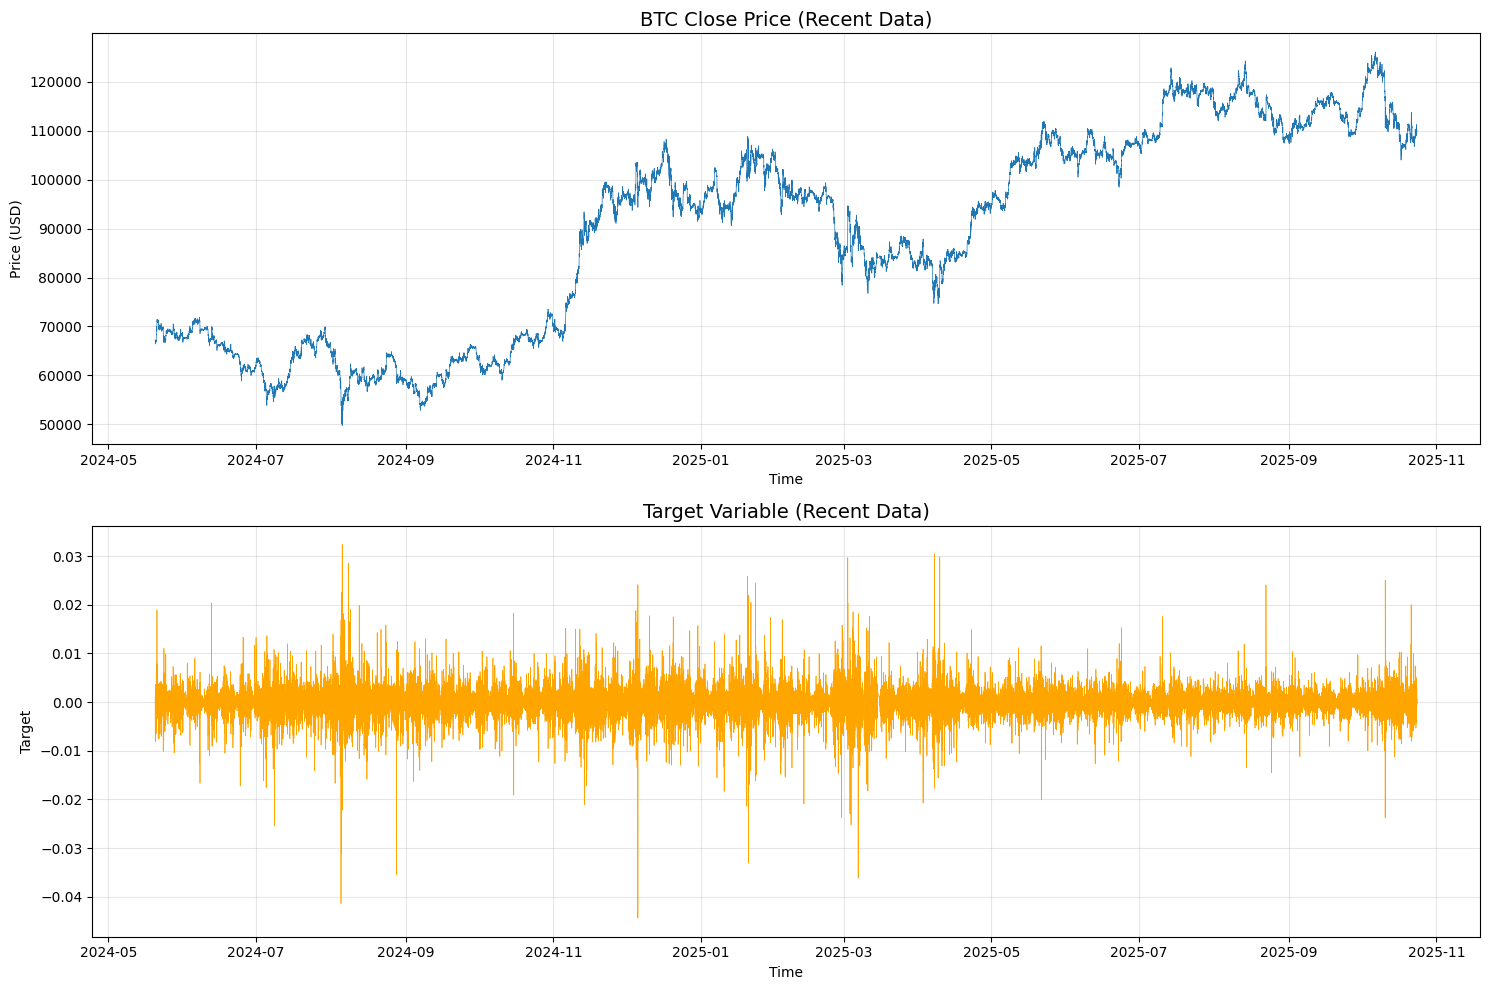

In [4]:
# 价格和目标走势图
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 使用最近的数据
plot_data = train_df.tail(50000)

axes[0].plot(plot_data['Timestamp'], plot_data['Close'], linewidth=0.5)
axes[0].set_title('BTC Close Price (Recent Data)', fontsize=14)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(plot_data['Timestamp'], plot_data['Target'], linewidth=0.5, color='orange')
axes[1].set_title('Target Variable (Recent Data)', fontsize=14)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Target')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# 相关性分析
print("特征与Target的相关系数:")
train_df.corr()['Target'].sort_values(ascending=False)

特征与Target的相关系数:


Target       1.000000
Volume       0.026614
Timestamp   -0.001956
High        -0.001986
Open        -0.002005
Low         -0.002013
Close       -0.002013
Name: Target, dtype: float64

In [6]:
# 平稳性检验
def check_stationarity(series, name="Series"):
    """使用 ADF 检验检查平稳性"""
    # 采样以加速
    sample = series.dropna().values[-50000:]
    result = adfuller(sample)
    
    print(f"\n{'='*50}")
    print(f"平稳性检验: {name}")
    print(f"{'='*50}")
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    
    if result[1] <= 0.05:
        print("✅ 平稳序列 (Stationary)")
        return True
    else:
        print("❌ 非平稳序列 (Non-stationary)")
        return False

check_stationarity(train_df['Target'], "Target")


平稳性检验: Target
ADF Statistic: -30.344373
p-value: 0.000000
✅ 平稳序列 (Stationary)


True

## 4. 特征工程 (vbmokin 高级方法)

In [7]:
def create_advanced_features(df, is_train=True):
    """
    vbmokin 高级特征工程
    包含：OHLC技术特征、滞后特征、滚动统计、技术指标
    """
    df = df.copy()
    
    # =============================================
    # 1. 时间特征
    # =============================================
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['quarter'] = df['Timestamp'].dt.quarter
    
    # 周期性编码
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # =============================================
    # 2. OHLC 技术特征 (vbmokin style)
    # =============================================
    # 基础特征
    df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df['high2low'] = (df['High'] / (df['Low'] + 1e-10)).replace([np.inf, -np.inf], 0.)
    df['close2open'] = (df['Close'] / (df['Open'] + 1e-10)).replace([np.inf, -np.inf], 0.)
    
    # 价格范围
    df['price_range'] = df['High'] - df['Low']
    df['body_size'] = abs(df['Close'] - df['Open'])
    df['body_direction'] = np.sign(df['Close'] - df['Open'])
    
    # 收益率
    df['return_1'] = df['Close'].pct_change(1)
    df['return_4'] = df['Close'].pct_change(4)
    df['return_24'] = df['Close'].pct_change(24)
    df['return_96'] = df['Close'].pct_change(96)
    
    # 对数收益率
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # =============================================
    # 3. 成交量特征
    # =============================================
    df['volume_log'] = np.log1p(df['Volume'])
    df['volume_change'] = df['Volume'].pct_change(1)
    df['volume_ma_4'] = df['Volume'].shift(1).rolling(4).mean()
    df['volume_ma_24'] = df['Volume'].shift(1).rolling(24).mean()
    df['volume_ratio'] = df['Volume'] / (df['volume_ma_24'] + 1e-10)
    
    # 价量关系
    df['price_volume'] = df['return_1'] * df['volume_log']
    
    # =============================================
    # 4. 技术指标
    # =============================================
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # 布林带
    df['bb_middle'] = df['Close'].rolling(20).mean()
    df['bb_std'] = df['Close'].rolling(20).std()
    df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / (df['bb_middle'] + 1e-10)
    df['bb_position'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-10)
    
    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # 移动平均线
    for window in [4, 12, 24, 48, 96]:
        df[f'sma_{window}'] = df['Close'].shift(1).rolling(window).mean()
        df[f'close_sma_ratio_{window}'] = df['Close'] / (df[f'sma_{window}'] + 1e-10)
    
    # ATR
    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean()
    
    # =============================================
    # 5. 滞后特征
    # =============================================
    target_col = 'Target' if is_train and 'Target' in df.columns else 'Close'
    
    for lag in [1, 2, 3, 4, 6, 12, 24, 48, 96]:
        df[f'target_lag_{lag}'] = df[target_col].shift(lag)
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    
    # =============================================
    # 6. 滚动统计特征
    # =============================================
    for window in [4, 12, 24, 48, 96]:
        # 目标变量滚动统计
        df[f'target_rolling_mean_{window}'] = df[target_col].shift(1).rolling(window).mean()
        df[f'target_rolling_std_{window}'] = df[target_col].shift(1).rolling(window).std()
        df[f'target_rolling_min_{window}'] = df[target_col].shift(1).rolling(window).min()
        df[f'target_rolling_max_{window}'] = df[target_col].shift(1).rolling(window).max()
        
        # 价格滚动统计
        df[f'close_rolling_mean_{window}'] = df['Close'].shift(1).rolling(window).mean()
        df[f'close_rolling_std_{window}'] = df['Close'].shift(1).rolling(window).std()
        
        # 波动率
        df[f'volatility_{window}'] = df['log_return'].shift(1).rolling(window).std() * np.sqrt(window)
    
    # =============================================
    # 7. 差分特征
    # =============================================
    if is_train and 'Target' in df.columns:
        df['target_diff_1'] = df['Target'].diff(1)
        df['target_diff_4'] = df['Target'].diff(4)
        df['target_diff_24'] = df['Target'].diff(24)
    
    # 价格差分
    df['close_diff_1'] = df['Close'].diff(1)
    df['close_diff_4'] = df['Close'].diff(4)
    
    # =============================================
    # 8. 动量特征
    # =============================================
    for period in [4, 12, 24, 48]:
        df[f'momentum_{period}'] = df['Close'] - df['Close'].shift(period)
        df[f'roc_{period}'] = (df['Close'] - df['Close'].shift(period)) / (df['Close'].shift(period) + 1e-10) * 100
    
    return df

print("✅ 特征工程函数定义完成")

✅ 特征工程函数定义完成


In [8]:
# 创建训练集特征
print("创建训练集特征...")
train_featured = create_advanced_features(train_df.copy(), is_train=True)

print(f"原始列数: {train_df.shape[1]}")
print(f"特征后列数: {train_featured.shape[1]}")
print(f"新增特征数: {train_featured.shape[1] - train_df.shape[1]}")

创建训练集特征...
原始列数: 7
特征后列数: 121
新增特征数: 114
原始列数: 7
特征后列数: 121
新增特征数: 114


In [9]:
# 定义特征列
exclude_cols = ['Timestamp', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'bb_middle', 'bb_std']
feature_cols = [col for col in train_featured.columns if col not in exclude_cols]

print(f"特征数量: {len(feature_cols)}")
print(f"\n特征列表 (前30个):")
for i, col in enumerate(feature_cols[:30], 1):
    print(f"{i:3d}. {col}")

特征数量: 112

特征列表 (前30个):
  1. hour
  2. day_of_week
  3. day_of_month
  4. month
  5. quarter
  6. hour_sin
  7. hour_cos
  8. day_sin
  9. day_cos
 10. Upper_Shadow
 11. Lower_Shadow
 12. high2low
 13. close2open
 14. price_range
 15. body_size
 16. body_direction
 17. return_1
 18. return_4
 19. return_24
 20. return_96
 21. log_return
 22. volume_log
 23. volume_change
 24. volume_ma_4
 25. volume_ma_24
 26. volume_ratio
 27. price_volume
 28. rsi_14
 29. bb_upper
 30. bb_lower


## 5. 数据准备

In [10]:
# 保存时间戳
timestamps = train_featured['Timestamp'].copy()

# 处理无穷值和缺失值
train_featured = train_featured.replace([np.inf, -np.inf], np.nan)

# 删除包含 NaN 的行
valid_idx = train_featured[feature_cols + ['Target']].notna().all(axis=1)
train_clean = train_featured[valid_idx].reset_index(drop=True)
timestamps_clean = timestamps[valid_idx].reset_index(drop=True)

print(f"清洗前数据量: {len(train_featured):,}")
print(f"清洗后数据量: {len(train_clean):,}")
print(f"保留比例: {len(train_clean) / len(train_featured) * 100:.2f}%")

清洗前数据量: 484,202
清洗后数据量: 457,718
保留比例: 94.53%


In [11]:
# 准备特征和目标
X = train_clean[feature_cols].values.astype(np.float32)
y = train_clean['Target'].values.astype(np.float32)

# 时间序列分割 (80% 训练, 20% 验证)
val_ratio = 0.2
train_size = int(len(X) * (1 - val_ratio))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]

print(f"训练集: {X_train.shape[0]:,} 样本")
print(f"验证集: {X_val.shape[0]:,} 样本")
print(f"\n训练集时间: {timestamps_clean.iloc[0]} 到 {timestamps_clean.iloc[train_size-1]}")
print(f"验证集时间: {timestamps_clean.iloc[train_size]} 到 {timestamps_clean.iloc[-1]}")

训练集: 366,174 样本
验证集: 91,544 样本

训练集时间: 2012-01-03 01:15:00 到 2023-03-14 02:45:00
验证集时间: 2023-03-14 03:00:00 到 2025-10-23 23:15:00


## 6. 多模型训练与评估 (vbmokin 集成方法)

In [18]:
# 定义多个模型 (简化版本，提高兼容性)
models = {
    'LightGBM': LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=8,
        min_child_samples=100,
        feature_fraction=0.7,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=random_state,
        n_jobs=-1,
        verbose=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,  # 减少迭代次数
        learning_rate=0.03,
        max_depth=8,
        min_child_weight=100,
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=random_state,
        n_jobs=-1,
        verbosity=0
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=100,  # 减少树数量
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=random_state,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,  # 减少迭代次数
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=50,
        min_samples_leaf=20,
        subsample=0.8,
        random_state=random_state
    )
}

print(f"定义了 {len(models)} 个模型: {list(models.keys())}")

定义了 4 个模型: ['LightGBM', 'XGBoost', 'RandomForest', 'GradientBoosting']


In [19]:
# 初始化结果存储
results = []
trained_models = {}

In [20]:
# 训练模型 1: LightGBM
print("="*60)
print("训练模型: LightGBM")
print("="*60)

lgb_model = models['LightGBM']
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(100)]
)

y_pred = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr, _ = stats.pearsonr(y_val, y_pred)

results.append({'Model': 'LightGBM', 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Correlation': corr})
trained_models['LightGBM'] = lgb_model

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Pearson相关系数: {corr:.6f}")

训练模型: LightGBM
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 1.92047e-08
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 1.92047e-08
RMSE: 0.000139
MAE: 0.000079
R²: 0.996894
Pearson相关系数: 0.998464
RMSE: 0.000139
MAE: 0.000079
R²: 0.996894
Pearson相关系数: 0.998464


In [21]:
# 训练模型 2: XGBoost
print("="*60)
print("训练模型: XGBoost")
print("="*60)

xgb_model = models['XGBoost']
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr, _ = stats.pearsonr(y_val, y_pred)

results.append({'Model': 'XGBoost', 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Correlation': corr})
trained_models['XGBoost'] = xgb_model

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Pearson相关系数: {corr:.6f}")

训练模型: XGBoost
RMSE: 0.000141
MAE: 0.000081
R²: 0.996801
Pearson相关系数: 0.998424
RMSE: 0.000141
MAE: 0.000081
R²: 0.996801
Pearson相关系数: 0.998424


In [22]:
# 训练模型 3: RandomForest
print("="*60)
print("训练模型: RandomForest")
print("="*60)

rf_model = models['RandomForest']
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr, _ = stats.pearsonr(y_val, y_pred)

results.append({'Model': 'RandomForest', 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Correlation': corr})
trained_models['RandomForest'] = rf_model

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Pearson相关系数: {corr:.6f}")

训练模型: RandomForest
RMSE: 0.000887
MAE: 0.000613
R²: 0.872600
Pearson相关系数: 0.970715
RMSE: 0.000887
MAE: 0.000613
R²: 0.872600
Pearson相关系数: 0.970715


In [26]:
# 训练模型 4: GradientBoosting (快速版本)
print("="*60)
print("训练模型: GradientBoosting")
print("="*60)

# 大幅减少参数以加速训练
gb_model = GradientBoostingRegressor(
    n_estimators=30,      # 从100减到30
    learning_rate=0.1,    # 提高学习率
    max_depth=4,          # 从6减到4
    min_samples_split=100,
    min_samples_leaf=50,
    subsample=0.5,        # 减少采样
    random_state=random_state,
    verbose=1
)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr, _ = stats.pearsonr(y_val, y_pred)

results.append({'Model': 'GradientBoosting', 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Correlation': corr})
trained_models['GradientBoosting'] = gb_model

print(f"\nRMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Pearson相关系数: {corr:.6f}")

训练模型: GradientBoosting
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0000           0.0000            4.62m
         1           0.0000           0.0000            4.62m
         2           0.0000           0.0000            4.60m
         2           0.0000           0.0000            4.60m
         3           0.0000           0.0000            4.46m
         3           0.0000           0.0000            4.46m
         4           0.0000           0.0000            4.28m
         4           0.0000           0.0000            4.28m
         5           0.0000           0.0000            4.05m
         5           0.0000           0.0000            4.05m
         6           0.0000           0.0000            3.87m
         6           0.0000           0.0000            3.87m
         7           0.0000           0.0000            3.69m
         7           0.0000           0.0000            3.69m
         8           0.0000          -0.0000  

In [27]:
# 模型评估结果汇总
results_df = pd.DataFrame(results).sort_values('RMSE')
print("="*60)
print("模型评估结果汇总 (按RMSE排序):")
print("="*60)
print(results_df.to_string(index=False))

模型评估结果汇总 (按RMSE排序):
           Model     RMSE      MAE       R2  Correlation
        LightGBM 0.000139 0.000079 0.996894     0.998464
         XGBoost 0.000141 0.000081 0.996801     0.998424
GradientBoosting 0.000826 0.000597 0.889633     0.957788
    RandomForest 0.000887 0.000613 0.872600     0.970715


In [28]:
# 选择最佳模型
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.6f}")
print(f"   相关系数: {results_df.iloc[0]['Correlation']:.6f}")


🏆 最佳模型: LightGBM
   RMSE: 0.000139
   相关系数: 0.998464


## 7. 特征重要性分析

Top 30 重要特征 (LightGBM):
              feature  importance
        target_lag_24        2225
        target_diff_1        2221
         target_lag_4        2180
       target_diff_24        1972
        target_diff_4        1930
             return_1        1871
           log_return         660
         target_lag_2         642
         target_lag_3         584
         close_diff_1         447
 target_rolling_max_4         404
         close_diff_4         403
         price_volume         379
 target_rolling_std_4         353
 target_rolling_min_4         351
        volume_change         347
             high2low         330
            body_size         312
         volume_ratio         309
target_rolling_max_48         305
          momentum_24         302
           volume_log         300
    close_sma_ratio_4         286
         Lower_Shadow         253
target_rolling_max_12         243
target_rolling_max_24         241
         Upper_Shadow         240
          bb_position   

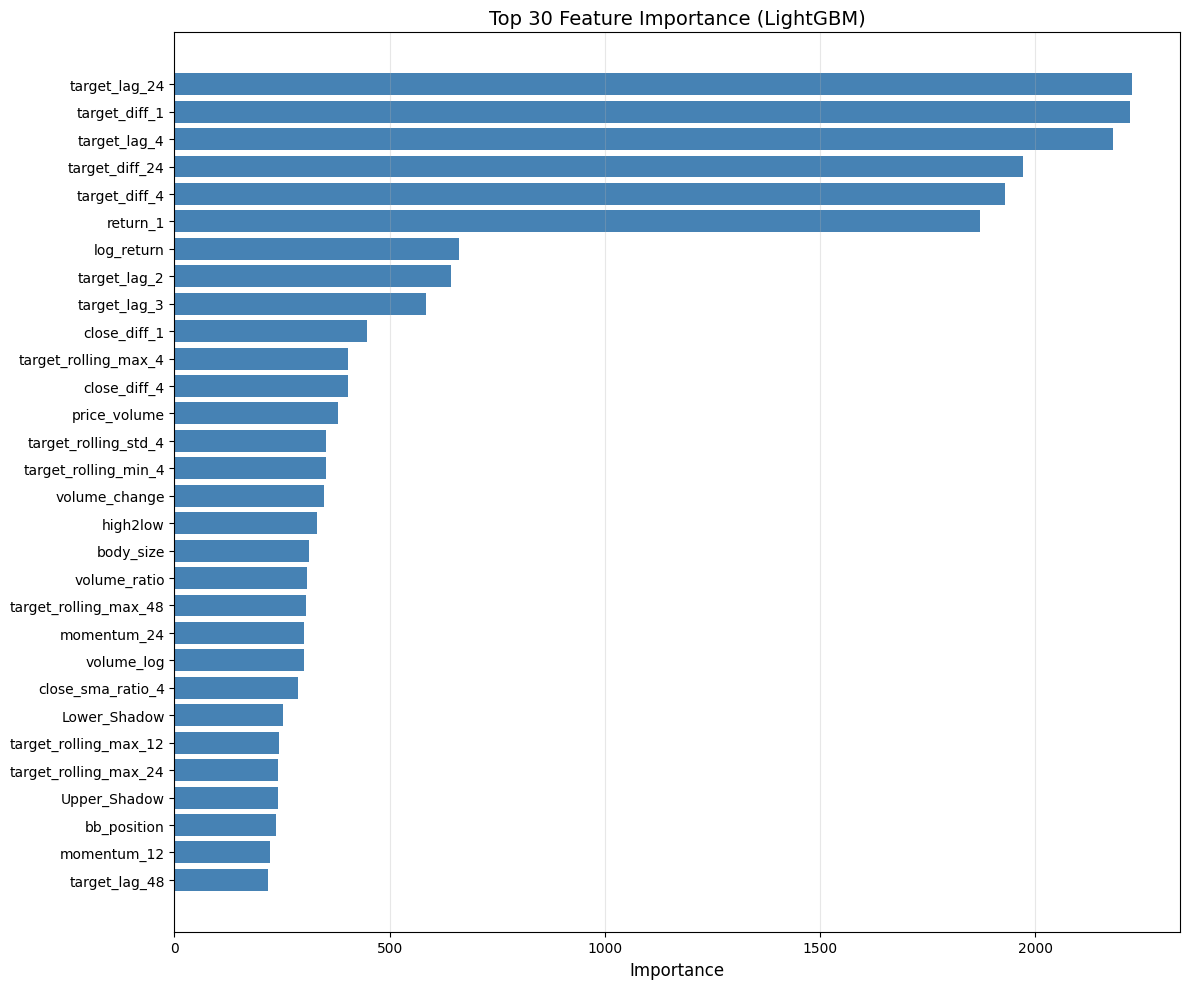

In [29]:
# 获取特征重要性 (从最佳模型)
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"Top 30 重要特征 ({best_model_name}):")
    print(feature_importance_df.head(30).to_string(index=False))
    
    # 可视化
    top_n = 30
    top_features = feature_importance_df.head(top_n)
    
    plt.figure(figsize=(12, 10))
    plt.barh(range(top_n), top_features['importance'].values, color='steelblue')
    plt.yticks(range(top_n), top_features['feature'].values)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importance ({best_model_name})', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

## 8. 模型集成预测

In [30]:
# 集成预测 (加权平均)
# 权重基于验证集表现 (RMSE的倒数)
weights = {}
total_weight = 0
for result in results:
    w = 1.0 / result['RMSE']
    weights[result['Model']] = w
    total_weight += w

# 归一化权重
for name in weights:
    weights[name] /= total_weight

print("模型权重:")
for name, w in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {w:.4f}")

模型权重:
  LightGBM: 0.4330
  XGBoost: 0.4267
  GradientBoosting: 0.0726
  RandomForest: 0.0676


In [31]:
# 在验证集上测试集成效果
ensemble_pred = np.zeros(len(X_val))
for name, model in trained_models.items():
    pred = model.predict(X_val)
    ensemble_pred += weights[name] * pred

# 评估集成模型
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
ensemble_corr, _ = stats.pearsonr(y_val, ensemble_pred)

print(f"\n集成模型验证集性能:")
print(f"  RMSE: {ensemble_rmse:.6f}")
print(f"  相关系数: {ensemble_corr:.6f}")
print(f"\n对比最佳单模型 ({best_model_name}):")
print(f"  RMSE: {results_df.iloc[0]['RMSE']:.6f}")
print(f"  相关系数: {results_df.iloc[0]['Correlation']:.6f}")


集成模型验证集性能:
  RMSE: 0.000179
  相关系数: 0.998361

对比最佳单模型 (LightGBM):
  RMSE: 0.000139
  相关系数: 0.998464


## 9. 测试集预测

In [32]:
# 准备测试集
max_lag = 96 + 96  # 需要的历史数据

# 从训练集获取历史数据
train_tail = train_df.tail(max_lag).copy()

# 合并历史数据和测试集
test_with_history = pd.concat([train_tail, test_df], ignore_index=True)

print(f"训练集尾部: {len(train_tail)} 行")
print(f"测试集: {len(test_df)} 行")
print(f"合并后: {len(test_with_history)} 行")

训练集尾部: 192 行
测试集: 2881 行
合并后: 3073 行


In [33]:
# 创建测试集特征
print("创建测试集特征...")
test_featured = create_advanced_features(test_with_history.copy(), is_train=False)

# 只保留原始测试集行
test_featured = test_featured.tail(len(test_df)).reset_index(drop=True)

print(f"测试集特征形状: {test_featured.shape}")

创建测试集特征...
测试集特征形状: (2881, 118)


In [34]:
# 确保测试集有所有特征
available_features = [col for col in feature_cols if col in test_featured.columns]
missing_features = set(feature_cols) - set(available_features)

print(f"可用特征: {len(available_features)}/{len(feature_cols)}")

if missing_features:
    print(f"缺失特征: {missing_features}")
    for feat in missing_features:
        test_featured[feat] = 0

# 准备测试特征
X_test = test_featured[feature_cols].values.astype(np.float32)

# 处理 NaN 和 Inf
X_test = np.where(np.isinf(X_test), np.nan, X_test)
if np.isnan(X_test).any():
    print("处理测试集 NaN 值...")
    train_means = np.nanmean(X_train, axis=0)
    for i in range(X_test.shape[1]):
        mask = np.isnan(X_test[:, i])
        if mask.any():
            X_test[mask, i] = train_means[i] if not np.isnan(train_means[i]) else 0

print(f"测试集特征矩阵: {X_test.shape}")
print(f"NaN: {np.isnan(X_test).any()}, Inf: {np.isinf(X_test).any()}")

可用特征: 109/112
缺失特征: {'target_diff_24', 'target_diff_1', 'target_diff_4'}
测试集特征矩阵: (2881, 112)
NaN: False, Inf: False


In [35]:
# 集成预测
print("进行集成预测...")
test_predictions = np.zeros(len(X_test))
for name, model in trained_models.items():
    pred = model.predict(X_test)
    test_predictions += weights[name] * pred
    print(f"  {name}: 完成")

print(f"\n预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

进行集成预测...
  LightGBM: 完成
  XGBoost: 完成
  RandomForest: 完成
  GradientBoosting: 完成

预测完成!
预测数量: 2881
预测值范围: [0.001282, 0.016749]
预测值均值: 0.006663
预测值标准差: 0.001266


## 10. 生成提交文件

In [36]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'],
    'Prediction': test_predictions
})

# 保存
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'vbmokin_advanced_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件预览:")
print(submission_df.head(10))
print("\n...")
print(submission_df.tail(10))

✅ 提交文件已保存: ..\submissions\vbmokin_advanced_submission.csv

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.006225
1 2025-10-23 23:45:00    0.006385
2 2025-10-24 00:00:00    0.007273
3 2025-10-24 00:15:00    0.005786
4 2025-10-24 00:30:00    0.007218
5 2025-10-24 00:45:00    0.007037
6 2025-10-24 01:00:00    0.005782
7 2025-10-24 01:15:00    0.005135
8 2025-10-24 01:30:00    0.006905
9 2025-10-24 01:45:00    0.007301

...
               Timestamp  Prediction
2871 2025-11-22 21:15:00    0.006806
2872 2025-11-22 21:30:00    0.007182
2873 2025-11-22 21:45:00    0.006755
2874 2025-11-22 22:00:00    0.007405
2875 2025-11-22 22:15:00    0.006394
2876 2025-11-22 22:30:00    0.007189
2877 2025-11-22 22:45:00    0.008618
2878 2025-11-22 23:00:00    0.005788
2879 2025-11-22 23:15:00    0.005189
2880 2025-11-22 23:30:00    0.006014


In [37]:
# 提交统计
print("\n提交文件统计:")
print(submission_df['Prediction'].describe())


提交文件统计:
count    2881.000000
mean        0.006663
std         0.001266
min         0.001282
25%         0.006023
50%         0.006550
75%         0.007246
max         0.016749
Name: Prediction, dtype: float64


## 11. 保存模型

In [ ]:
# 保存最佳模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# 保存 LightGBM 模型
if 'LightGBM' in trained_models:
    lgb_model = trained_models['LightGBM']
    lgb_model.booster_.save_model(str(model_dir / 'vbmokin_lgbm_model.txt'))
    print(f"✅ LightGBM 模型已保存")

# 保存特征列表
feature_file = model_dir / 'vbmokin_features.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"✅ 特征列表已保存: {feature_file}")

# 保存模型权重
weights_file = model_dir / 'vbmokin_model_weights.txt'
with open(weights_file, 'w') as f:
    for name, w in weights.items():
        f.write(f"{name}: {w}\n")
print(f"✅ 模型权重已保存: {weights_file}")

## 总结

### vbmokin 高级分析方法核心:

1. **丰富的特征工程**:
   - OHLC 技术特征 (Upper/Lower Shadow, high2low)
   - 技术指标 (RSI, MACD, 布林带, ATR)
   - 多时间尺度滞后特征
   - 滚动窗口统计
   - 动量和收益率特征

2. **多模型集成**:
   - LightGBM
   - XGBoost
   - RandomForest
   - GradientBoosting
   - 加权平均集成

3. **时间序列验证**:
   - 严格的时间序列分割
   - 避免前瞻偏差